In [1]:

import os
from os.path import join
import yaml
import pickle

import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.style.use('../paper.mcstyle')

import seaborn as sns
import pandas as pd

import numpy as np
from scipy.stats import norm
import torch

import ili
from ili.dataloaders import StaticNumpyLoader, SBISimulator
from ili.validation.runner import ValidationRunner 
from ili.validation.metrics import PosteriorCoverage, PlotSinglePosterior


from CASBI.generator.fff.fff_model import FreeFormFlow
from CASBI.utils.create_dataframe import rescale


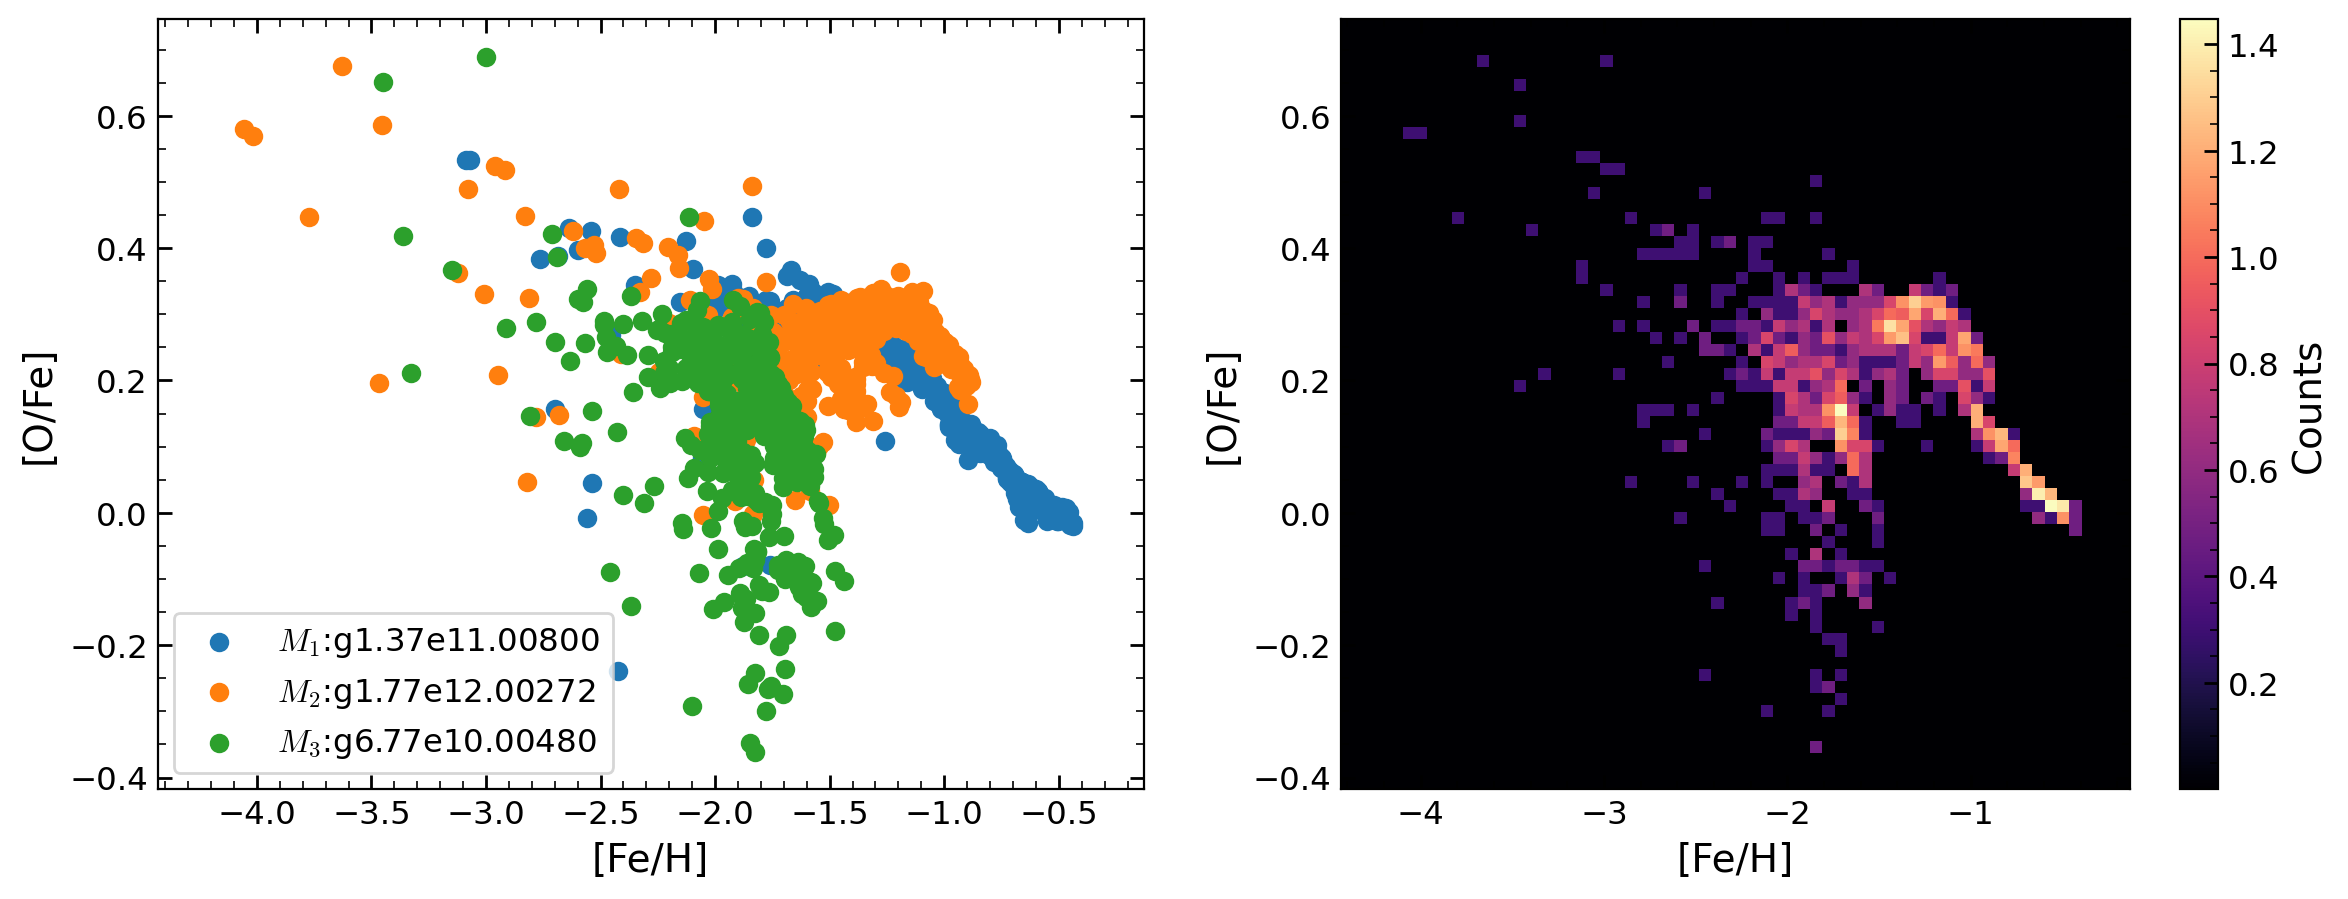

In [4]:
data = pd.read_parquet('../../../../data/dataframe/dataframe.parquet')
data = rescale(data, mean_and_std_path='../../../../data/preprocess/mean_and_std.parquet', scale_observations=True, scale_parameter=True, inverse=True) 
data =  data.drop(['gas_log10mass', 'a','redshift', 'mean_metallicity', 'std_metallicity','mean_FeMassFrac', 'std_FeMassFrac', 'mean_OMassFrac', 'std_OMassFrac'], axis=1)
min_feh, max_feh = min(data['feh']), max(data['feh'])
min_ofe, max_ofe = min(data['ofe']), max(data['ofe'])

data_to_plot_halos = pd.read_parquet('./halos_0.parquet')

fig = plt.figure(figsize=(14,5))
ax = fig.add_subplot(121)
for i, galaxy in enumerate(data_to_plot_halos['Galaxy_name'].unique()):
    observables =  data_to_plot_halos[data_to_plot_halos['Galaxy_name'] == galaxy]
    ax.scatter(observables['feh'], observables['ofe'], label=f'$M_{i+1}$:{galaxy}',)
    ax.set_xlabel('[Fe/H]')   
    ax.set_ylabel('[O/Fe]')
    ax.set_xlim((min_feh, max_feh))
    ax.set_ylim((min_ofe, max_ofe))
    ax.legend()
ax = fig.add_subplot(122)
im = ax.imshow(np.load('x_0.npy').T, origin='lower', extent=[min_feh, max_feh, min_ofe, max_ofe], aspect='auto', cmap='magma')
ax.set_xlabel('[Fe/H]')   
ax.set_ylabel('[O/Fe]')
cbar = fig.colorbar(im, ax=ax, label='Counts')
cbar.set_label('Counts', size=14)

In [5]:
samples = {}
m = 'NPE'
with open(join('./', 'toy_NPE_posterior.pkl'), 'rb') as f:
    samples[m] = pickle.load(f)
posterio_samples = samples['NPE'].sample((5_000,), x=torch.from_numpy(np.load('./x_0.npy')).to('cuda'))

Drawing 2738 posterior samples:   0%|          | 0/2738 [00:00<?, ?it/s]

Drawing 1545 posterior samples:   0%|          | 0/1545 [00:00<?, ?it/s]

Drawing 717 posterior samples:   0%|          | 0/717 [00:00<?, ?it/s]

Drawing 2618 posterior samples:   0%|          | 0/2618 [00:00<?, ?it/s]

Drawing 1614 posterior samples:   0%|          | 0/1614 [00:00<?, ?it/s]

Drawing 768 posterior samples:   0%|          | 0/768 [00:00<?, ?it/s]

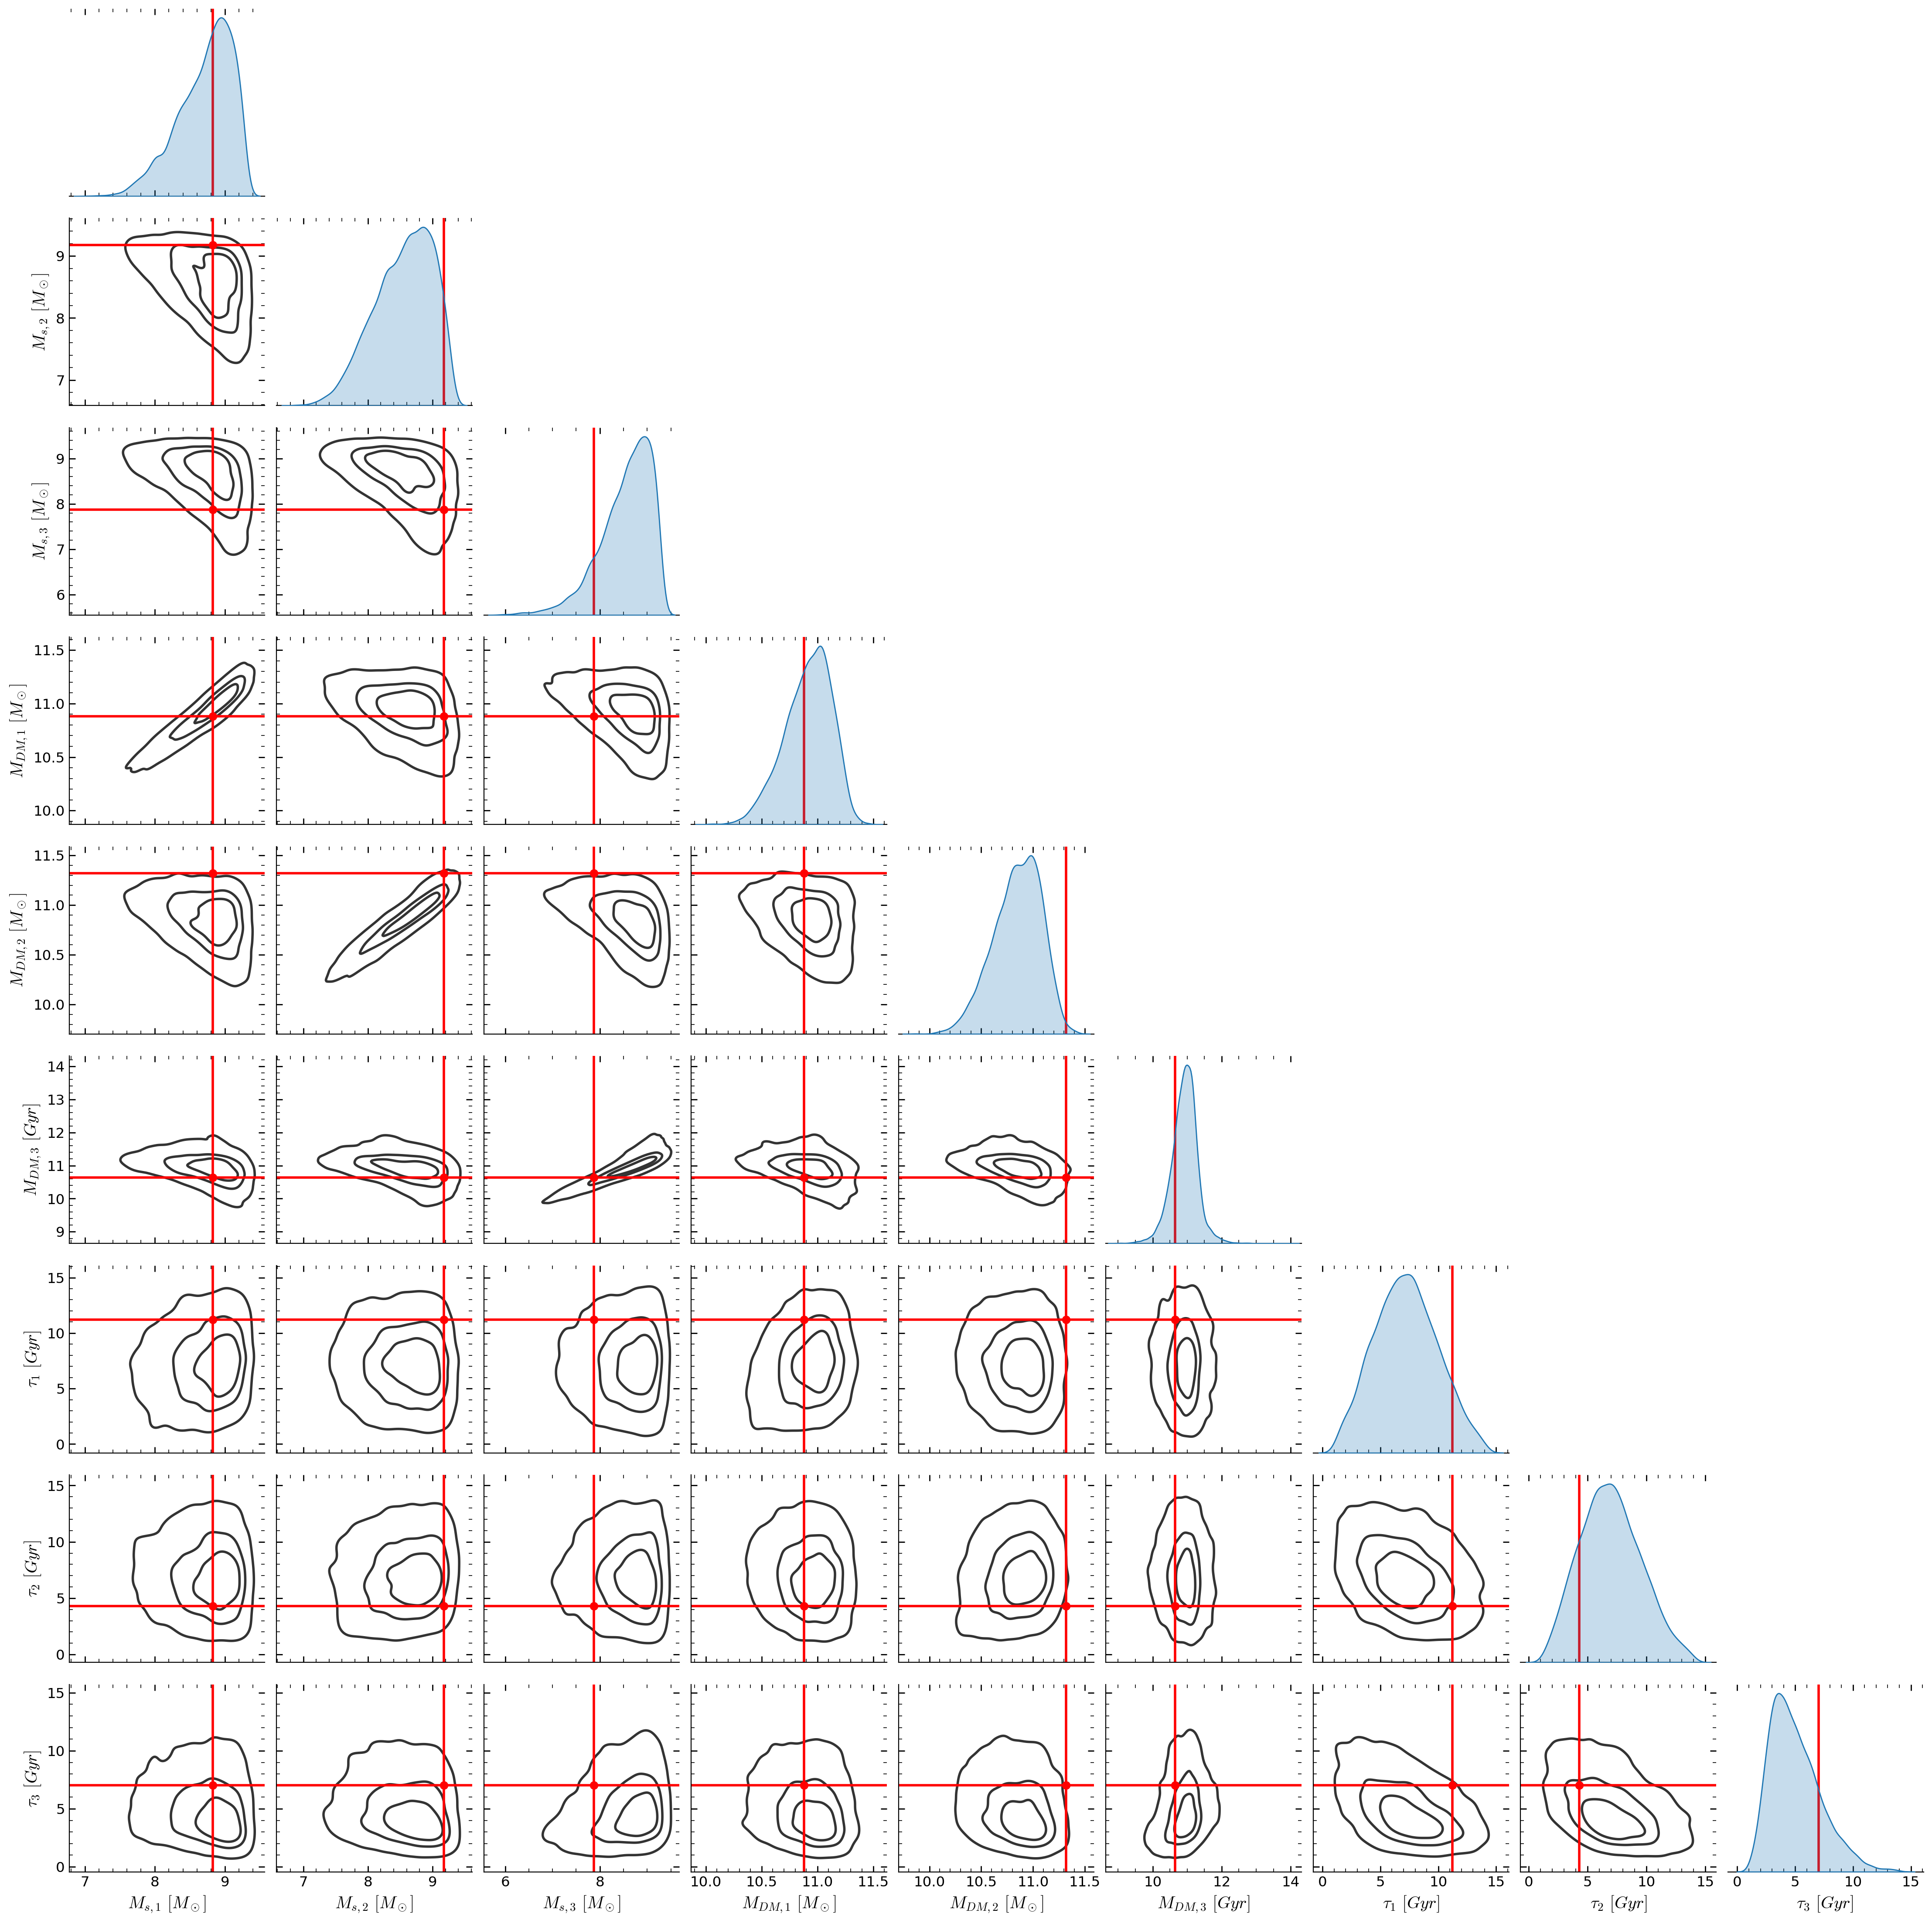

In [6]:
metric = PlotSinglePosterior(
    num_samples=5_000, sample_method='direct', 
    labels = [r'$M_{s, 1}\ [M_\odot]$', r'$M_{s, 2}\ [M_\odot]$', r'$M_{s, 3}\ [M_\odot]$', r'$M_{DM, 1}\ [M_\odot]$', r'$M_{DM, 2}\ [M_\odot]$', r'$M_{DM, 3}\ [Gyr]$', r'$\tau_{1}\ [Gyr]$', r'$\tau_{2}\ [Gyr]$', r'$\tau_{3}\ [Gyr]$ '],
    out_dir=None
)
fig = metric(
    posterior=samples[m],
    x_obs = torch.from_numpy(np.load('./x_0.npy')), theta_fid=torch.from_numpy(np.load('./theta_0.npy')),
)

In [ ]:
metric = PosteriorCoverage(
    num_samples=5000, sample_method='direct',
    labels=labels, plot_list = ["coverage", "histogram", "predictions", "tarp"]
)
fig = metric(
    posterior=samples[m],
    x=x[::8], theta=theta[::8]
)